In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2017,2018 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Isentropic Analysis

The MetPy function `mpcalc.isentropic_interpolation` allows for isentropic analysis from model
analysis data in isobaric coordinates.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, add_timestamp
from metpy.units import units

**Getting the data**

In this example, [NARR reanalysis data](
https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional)
for 18 UTC 04 April 1987 from the National Centers for Environmental Information will be
used.

In [4]:
data = xr.open_dataset(get_test_data('narr_example.nc', False))

In [5]:
print(list(data.variables))

['Temperature', 'Lambert_Conformal', 'lat', 'lon', 'u_wind', 'v_wind', 'Geopotential_height', 'Specific_humidity', 'time', 'isobaric', 'y', 'x']


We will reduce the dimensionality of the data as it is pulled in to remove an empty time
dimension, as well as add longitude and latitude as coordinates (instead of data variables).

In [6]:
data = data.squeeze().set_coords(['lon', 'lat'])

To properly interpolate to isentropic coordinates, the function must know the desired output
isentropic levels. An array with these levels will be created below.

In [7]:
isentlevs = [296.] * units.kelvin

**Conversion to Isentropic Coordinates**

Once three dimensional data in isobaric coordinates has been pulled and the desired
isentropic levels created, the conversion to isentropic coordinates can begin. Data will be
passed to the function as below. The function requires that isentropic levels, as well as a
DataArray of temperature on isobaric coordinates be input. Any additional inputs (in this
case specific humidity, geopotential height, and u and v wind components) will be
logarithmicaly interpolated to isentropic space.

In [8]:
isent_data = mpcalc.isentropic_interpolation_as_dataset(
    isentlevs,
    data['Temperature'],
    data['u_wind'],
    data['v_wind'],
    data['Specific_humidity'],
    data['Geopotential_height']
)

/var/folders/9w/czmy8vgn76376hx2704_y62w0000gp/T/ipykernel_37839/1619019870.py:1: UserWarning: Interpolation point out of data bounds encountered
  isent_data = mpcalc.isentropic_interpolation_as_dataset(


The output is an xarray Dataset:

In [9]:
isent_data

Magnitude,[[[900.3412466141666 900.6282002263883 902.6954128823945 ... nan nan nan] [898.7657927677703 899.3957330451849 901.1369631046779 ... nan nan nan] [893.4104553118616 894.6623958512805 896.9688329797301 ... nan nan nan] ... [582.3629328442938 575.0471009518434 567.6847140894419 ... 802.8899086222864 803.7246159207159 804.6379705007769] [578.6096930396801 570.8991740469492 563.2216412523484 ... 805.1512754403952 804.8142480497339 806.6181326510635] [574.5889551269233 566.5030728802834 558.5810569436891 ... 806.337127284374 805.6222086748181 802.7520376016056]]]
Units,hectopascal
Magnitude,[[[287.25340245256615 287.2795573040488 287.4678010688309 ... nan nan nan] [287.10969897713835 287.16717993275586 287.32591469161804 ... nan nan nan] [286.61986771514216 286.73456514566794 286.94557123352325 ... nan nan nan] ... [253.63209195921524 252.717632787544 251.78892602876513 ... 278.003694857879 278.0862415261764 278.1764957251152] [253.16397872663083 252.19545647830967 251.22174909805472 ... 278.2271864365298 278.19390637133625 278.37191674895575] [252.66008992959777 251.63907141231874 250.628598944255 ... 278.34420537550375 278.27367248968466 277.9900544878668]]]
Units,kelvin
Magnitude,[[[-13.192940863873579 -13.65521105416572 -13.558986233473753 ... nan nan nan] [-13.154258338549946 -12.98898740158556 -13.336929044329297 ... nan nan nan] [-12.389387286673662 -12.84766496710402 -12.39843211370755 ... nan nan nan] ... [16.320100145853495 16.248921495708363 16.271949897175634 ... 0.43525579995775143 0.4346660048174408 0.7816840383266607] [15.922591200947092 15.982942665930146 16.393562189155983 ... -0.3228415237644567 -0.008841481805433371 -0.7134184142966571] [15.441819471148744 16.037097609603688 16.108870219801343 ... -1.6896393580322404 -1.4068366627204918 -0.6618929663250147]]]
Units,meter/second
Magnitude,[[[0.06423312212716725 0.07479514517840502 -0.16838919556261756 ... nan nan nan] [1.1180292752741479 2.250400198749113 1.09121576156247 ... nan nan nan] [2.86035077803407 1.8788880201288427 2.9904647623598932 ... nan nan nan] ... [9.613002576722808 9.17917727649642 8.184948214882462 ... -3.1936276183372767 -3.2024544913787523 -2.7355462054862034] [9.72932757840096 8.739680329084159 8.594322262130637 ... -2.9011261628292515 -2.474369096654598 -1.4870536737766291] [9.75039654041651 9.148816761411762 8.764094179929586 ... -1.6580673585775005 -1.2225487839300844 -1.480311313867268]]]
Units,meter/second
Magnitude,[[[0.008842348434263451 0.008867832268411289 0.008968565810944646 ... nan nan nan] [0.008817476631944828 0.008827154165882183 0.008907068600540524 ... nan nan nan] [0.008702820998113201 0.008732749531454772 0.00879103717829932 ... nan nan nan] ... [0.0011029793308478778 0.0010157327657120657 0.0009286300454721762 ... 0.005122114633895553 0.005146296653073072 0.005172386155577597] [0.001058190557627944 0.0009681548405628573 0.000881584099386615 ... 0.005132649195315631 0.005147182989988041 0.005189398218805261] [0.001011427153191496 0.0009211118186668137 0.000835425230443694 ... 0.005119733826822042 0.00511949572818722 0.0050910906548427325]]]
Units,dimensionless
Magnitude,[[[1063.6606513260513 1061.442147344304 1041.4938116153148 ... nan nan nan] [1079.478028125831 1073.556038742922 1057.65625580821 ... nan nan nan] [1130.3143074681855 1119.0241948332095 1097.3894374693677 ... nan nan nan] ... [4295.995558709697 4389.615879082366 4484.595154991583 ... 1937.469363947836 1928.4660956108603 1918.6774766150363] [4337.046065967427 4436.491575694276 4536.385003616513 ... 1914.4659073477915 1916.8617994669742 1898.0090694255] [4381.8733564005515 4486.902635937249 4590.03668770943 ... 1902.9080146834372 1909.1451375862355 1937.4070179509597]]]


Note that the units on our wind variables are not ideal for plotting. Instead, let us
convert them to more appropriate values.

In [10]:
isent_data['u_wind'] = isent_data['u_wind'].metpy.convert_units('kt')
isent_data['v_wind'] = isent_data['v_wind'].metpy.convert_units('kt')

**Converting to Relative Humidity**

The NARR only gives specific humidity on isobaric vertical levels, so relative humidity will
have to be calculated after the interpolation to isentropic space.

In [11]:
isent_data['Relative_humidity'] = mpcalc.relative_humidity_from_specific_humidity(
    isent_data['pressure'],
    isent_data['temperature'],
    isent_data['Specific_humidity']
).metpy.convert_units('percent')

**Plotting the Isentropic Analysis**

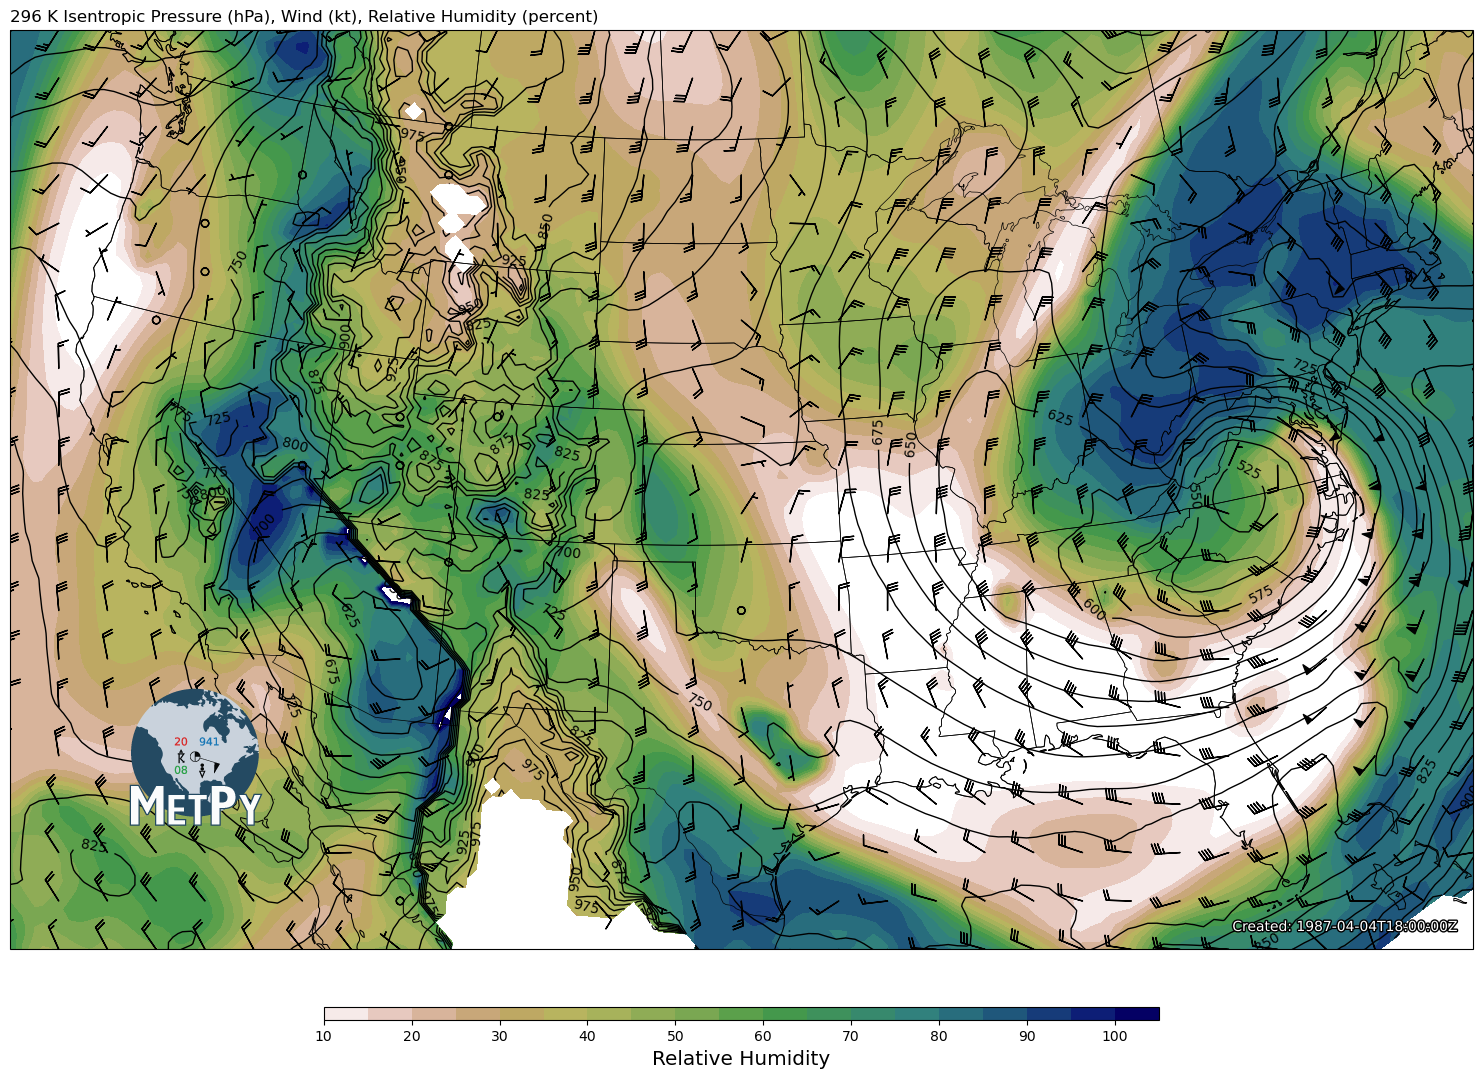

In [12]:
# Set up our projection and coordinates
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
lon = isent_data['pressure'].metpy.longitude
lat = isent_data['pressure'].metpy.latitude

# Coordinates to limit map area
bounds = [(-122., -75., 25., 50.)]
# Choose a level to plot, in this case 296 K (our sole level in this example)
level = 0

fig = plt.figure(figsize=(17., 12.))
add_metpy_logo(fig, 120, 245, size='large')
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(lon, lat, isent_data['pressure'].isel(isentropic_level=level),
                clevisent, colors='k', linewidths=1.0, linestyles='solid',
                transform=ccrs.PlateCarree())
cs.clabel(fontsize=10, inline=1, inline_spacing=7, fmt='%i', rightside_up=True,
          use_clabeltext=True)

# Plot RH
cf = ax.contourf(lon, lat, isent_data['Relative_humidity'].isel(isentropic_level=level),
                 range(10, 106, 5), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Relative Humidity', size='x-large')

# Plot wind barbs
ax.barbs(lon.values, lat.values, isent_data['u_wind'].isel(isentropic_level=level).values,
         isent_data['v_wind'].isel(isentropic_level=level).values, length=6,
         regrid_shape=20, transform=ccrs.PlateCarree())

# Make some titles
ax.set_title(f'{isentlevs[level]:~.0f} Isentropic Pressure (hPa), Wind (kt), '
             'Relative Humidity (percent)', loc='left')
add_timestamp(ax, isent_data['time'].values.astype('datetime64[ms]').astype('O'),
              y=0.02, high_contrast=True)
fig.tight_layout()

**Montgomery Streamfunction**

The Montgomery Streamfunction, ${\psi} = gdz + CpT$, is often desired because its
gradient is proportional to the geostrophic wind in isentropic space. This can be easily
calculated with `mpcalc.montgomery_streamfunction`.

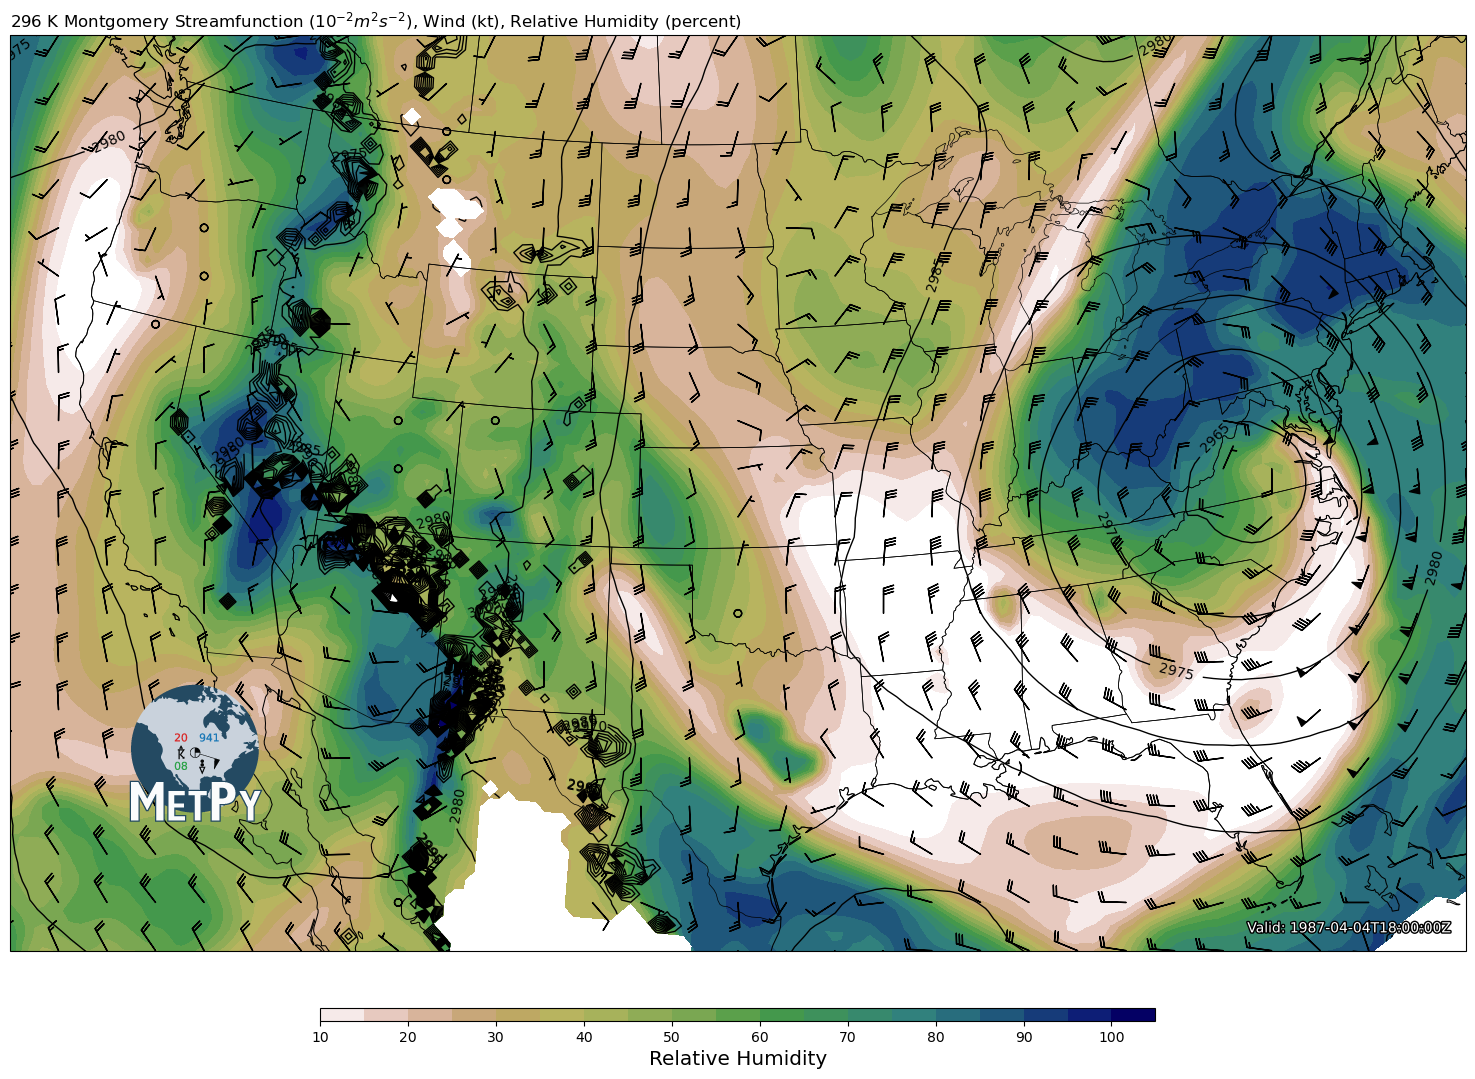

In [13]:

# Calculate Montgomery Streamfunction and scale by 10^-2 for plotting
msf = mpcalc.montgomery_streamfunction(
    isent_data['Geopotential_height'],
    isent_data['temperature']
).data.to_base_units() * 1e-2

# Choose a level to plot, in this case 296 K
level = 0

fig = plt.figure(figsize=(17., 12.))
add_metpy_logo(fig, 120, 250, size='large')
ax = plt.subplot(111, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)

# Plot the surface
clevmsf = np.arange(0, 4000, 5)
cs = ax.contour(lon, lat, msf[level, :, :], clevmsf,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
cs.clabel(fontsize=10, inline=1, inline_spacing=7, fmt='%i', rightside_up=True,
          use_clabeltext=True)

# Plot RH
cf = ax.contourf(lon, lat, isent_data['Relative_humidity'].isel(isentropic_level=level),
                 range(10, 106, 5), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Relative Humidity', size='x-large')

# Plot wind barbs
ax.barbs(lon.values, lat.values, isent_data['u_wind'].isel(isentropic_level=level).values,
         isent_data['v_wind'].isel(isentropic_level=level).values, length=6,
         regrid_shape=20, transform=ccrs.PlateCarree())

# Make some titles
ax.set_title(f'{isentlevs[level]:~.0f} Montgomery Streamfunction '
             r'($10^{-2} m^2 s^{-2}$), Wind (kt), Relative Humidity (percent)', loc='left')
add_timestamp(ax, isent_data['time'].values.astype('datetime64[ms]').astype('O'),
              y=0.02, pretext='Valid: ', high_contrast=True)

fig.tight_layout()
plt.show()